# NSL-KDD — EDA
This notebook performs EDA on NSL-KDD-style CSV files.
Goals: load data, overview, cleaning, filter attack families (e.g., DoS / SQL Injection), compute rule-complexity proxy, generate >=8 plots, and produce concise insights. Outputs saved to `outputs/`.

In [15]:
# Imports and plotting defaults
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_theme(style='whitegrid')
%matplotlib inline

In [16]:
import glob
import os
import pandas as pd

# 1️⃣ Find NSL-KDD TXT file(s) in workspace
search_patterns = []

# Search specifically inside nsl-kdd folder
search_patterns += glob.glob('datasets/nsl-kdd/**/*.txt', recursive=True)

search_patterns = sorted(search_patterns)

print('Found candidate files:', len(search_patterns))

for f in search_patterns[:40]:
    print('-', f)

# Raise error if nothing found
if not search_patterns:
    raise RuntimeError(
        'No NSL-KDD TXT files found. Check the folder path.'
    )

# 2️⃣ Load the first candidate file
fn = search_patterns[0]
print('Loading:', fn)

df = pd.read_csv(fn, header=None)

print('Loaded shape:', df.shape)
df.head()


Found candidate files: 4
- datasets/nsl-kdd\KDDTest+.txt
- datasets/nsl-kdd\KDDTest-21.txt
- datasets/nsl-kdd\KDDTrain+.txt
- datasets/nsl-kdd\KDDTrain+_20Percent.txt
Loading: datasets/nsl-kdd\KDDTest+.txt
Loaded shape: (22544, 43)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [17]:
# 2) Overview: rows, columns, dtypes, missing values
print('Rows:', df.shape[0])
print('Columns:', df.shape[1])
print('\nColumn names:')
print(list(df.columns))
print('\nData types count:')
print(df.dtypes.value_counts())

missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing': missing, 'percent': missing_percent})
missing_df.head(30)

Rows: 22544
Columns: 43

Column names:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

Data types count:
int64      24
float64    15
object      4
Name: count, dtype: int64


,missing,percent
0,0,0.0
32,0,0.0
24,0,0.0
25,0,0.0
26,0,0.0
27,0,0.0
28,0,0.0
29,0,0.0
30,0,0.0
31,0,0.0


Using column index as label: 43
is_attack
1    12833
0     9711
Name: count, dtype: int64


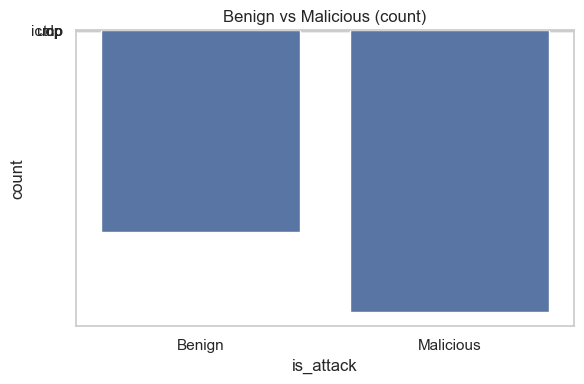

In [20]:
# NSL-KDD: label is second last column
label_index = df.shape[1] - 2

df['label'] = df.iloc[:, label_index].astype(str)

print("Using column index as label:", label_index)

# Normalize label text
df['label'] = df['label'].str.strip().str.lower()

# Create binary column: benign vs attack
df['is_attack'] = (~df['label'].isin(['normal', 'normal.'])).astype(int)

print(df['is_attack'].value_counts())

import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(6,4))
sns.countplot(x='is_attack', data=df)
plt.xticks([0,1], ['Benign','Malicious'])
plt.title('Benign vs Malicious (count)')
plt.tight_layout()
plt.savefig('outputs/nslkdd_benign_vs_malicious.png')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_79648\2208058537.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_attacks.values, y=top_attacks.index.astype(str), palette='magma')


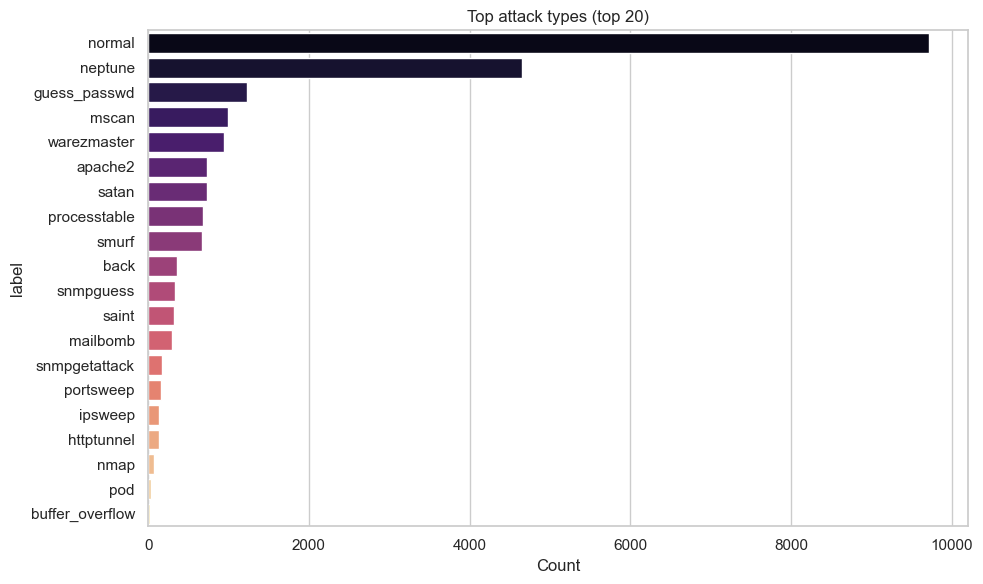

Attack family counts:
attack_family
other        21427
DoS-like      1115
SQLi-like        2
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_79648\2208058537.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='attack_family', data=df, order=df['attack_family'].value_counts().index, palette='pastel')


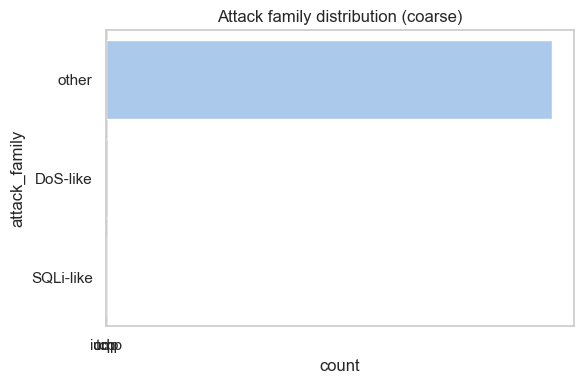

In [21]:
# 4) Top attack types (if available) and plot
top_attacks = df['label'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=top_attacks.values, y=top_attacks.index.astype(str), palette='magma')
plt.title('Top attack types (top 20)')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('outputs/nslkdd_top_attack_types.png')
plt.show()

# 5) Focused filtering: example subsets for DoS-like and SQL-injection-like attacks
dos_keys = ['dos','ddos','back','teardrop','apache2','land']
sql_keys = ['sql','injection','sql_injection']
df['attack_family'] = 'other'
for k in dos_keys:
    df.loc[df['label'].str.contains(k, na=False), 'attack_family'] = 'DoS-like'
for k in sql_keys:
    df.loc[df['label'].str.contains(k, na=False), 'attack_family'] = 'SQLi-like'

print('Attack family counts:')
print(df['attack_family'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(y='attack_family', data=df, order=df['attack_family'].value_counts().index, palette='pastel')
plt.title('Attack family distribution (coarse)')
plt.tight_layout()
plt.savefig('outputs/nslkdd_attack_family_distribution.png')
plt.show()

In [23]:
# 6) Rule complexity proxy: average string length of descriptive columns (payload/rule/service)
# Safely handle non-string column names by converting to str before lower()
rule_like = [c for c in df.columns if any(k in str(c).lower() for k in ('rule','signature','payload','content','desc','description'))]
print('Rule-like columns found:', rule_like)
if rule_like:
    rl = rule_like[0]
    df['_rule_len'] = df[rl].astype(str).fillna('').str.len()
    avg_len = df['_rule_len'].mean()
    print(f'Average rule-like length (column {rl}):', round(avg_len,2))
    plt.figure(figsize=(8,4))
    sns.histplot(df['_rule_len'].replace(0, np.nan).dropna(), bins=60, kde=True, color='purple')
    plt.title(f'Rule-like string length distribution ({rl})')
    plt.tight_layout()
    plt.savefig('outputs/nslkdd_rule_length_distribution.png')
    plt.show()
else:
    print('No rule-like descriptive columns found; skipping rule-complexity metric.')


Rule-like columns found: []
No rule-like descriptive columns found; skipping rule-complexity metric.


In [24]:
# 7) Protocol / service / port summaries (common NSL-KDD fields: protocol_type, service, flag)
for col in ['protocol_type','service','flag']:
    if col in df.columns:
        vc = df[col].value_counts().head(20)
        plt.figure(figsize=(8,4))
        sns.barplot(x=vc.values, y=vc.index.astype(str), palette='cool')
        plt.title(f'Top values for {col}')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig(f'outputs/nslkdd_top_{col}.png')
        plt.show()
    else:
        print(f'{col} not in DataFrame.')


protocol_type not in DataFrame.
service not in DataFrame.
flag not in DataFrame.


In [25]:
# 8) Numeric distributions: duration, src_bytes, dst_bytes (common NSL-KDD numeric features)
num_candidates = [c for c in ['duration','src_bytes','dst_bytes','count','srv_count'] if c in df.columns]
print('Numeric candidates for distribution plots:', num_candidates)
for c in num_candidates:
    plt.figure(figsize=(8,4))
    sns.histplot(df[c].replace([np.inf,-np.inf], np.nan).dropna(), bins=100, kde=True, color='teal')
    plt.title(f'Distribution of {c}')
    plt.xlim(left=0)
    plt.tight_layout()
    plt.savefig(f'outputs/nslkdd_dist_{c}.png')
    plt.show()


Numeric candidates for distribution plots: []


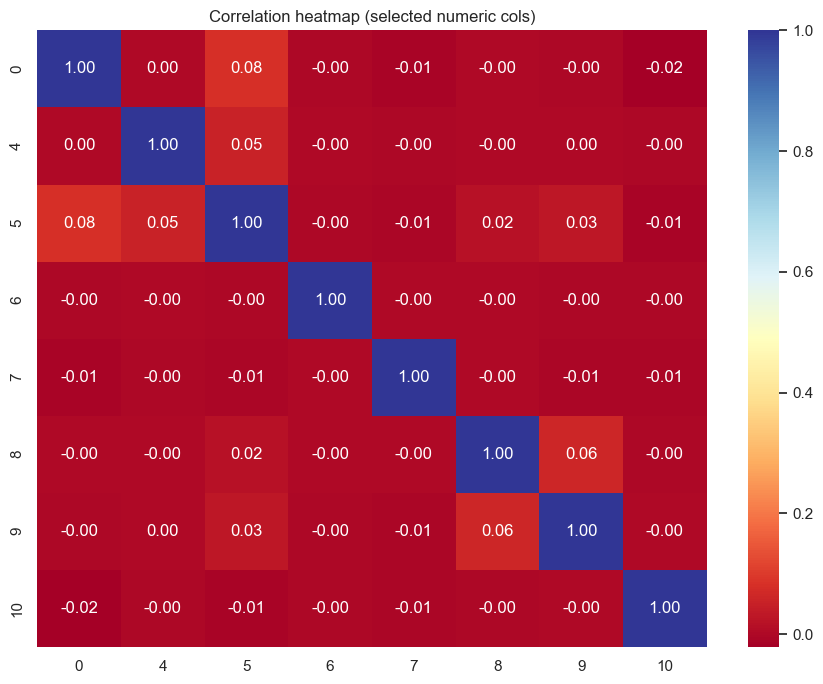

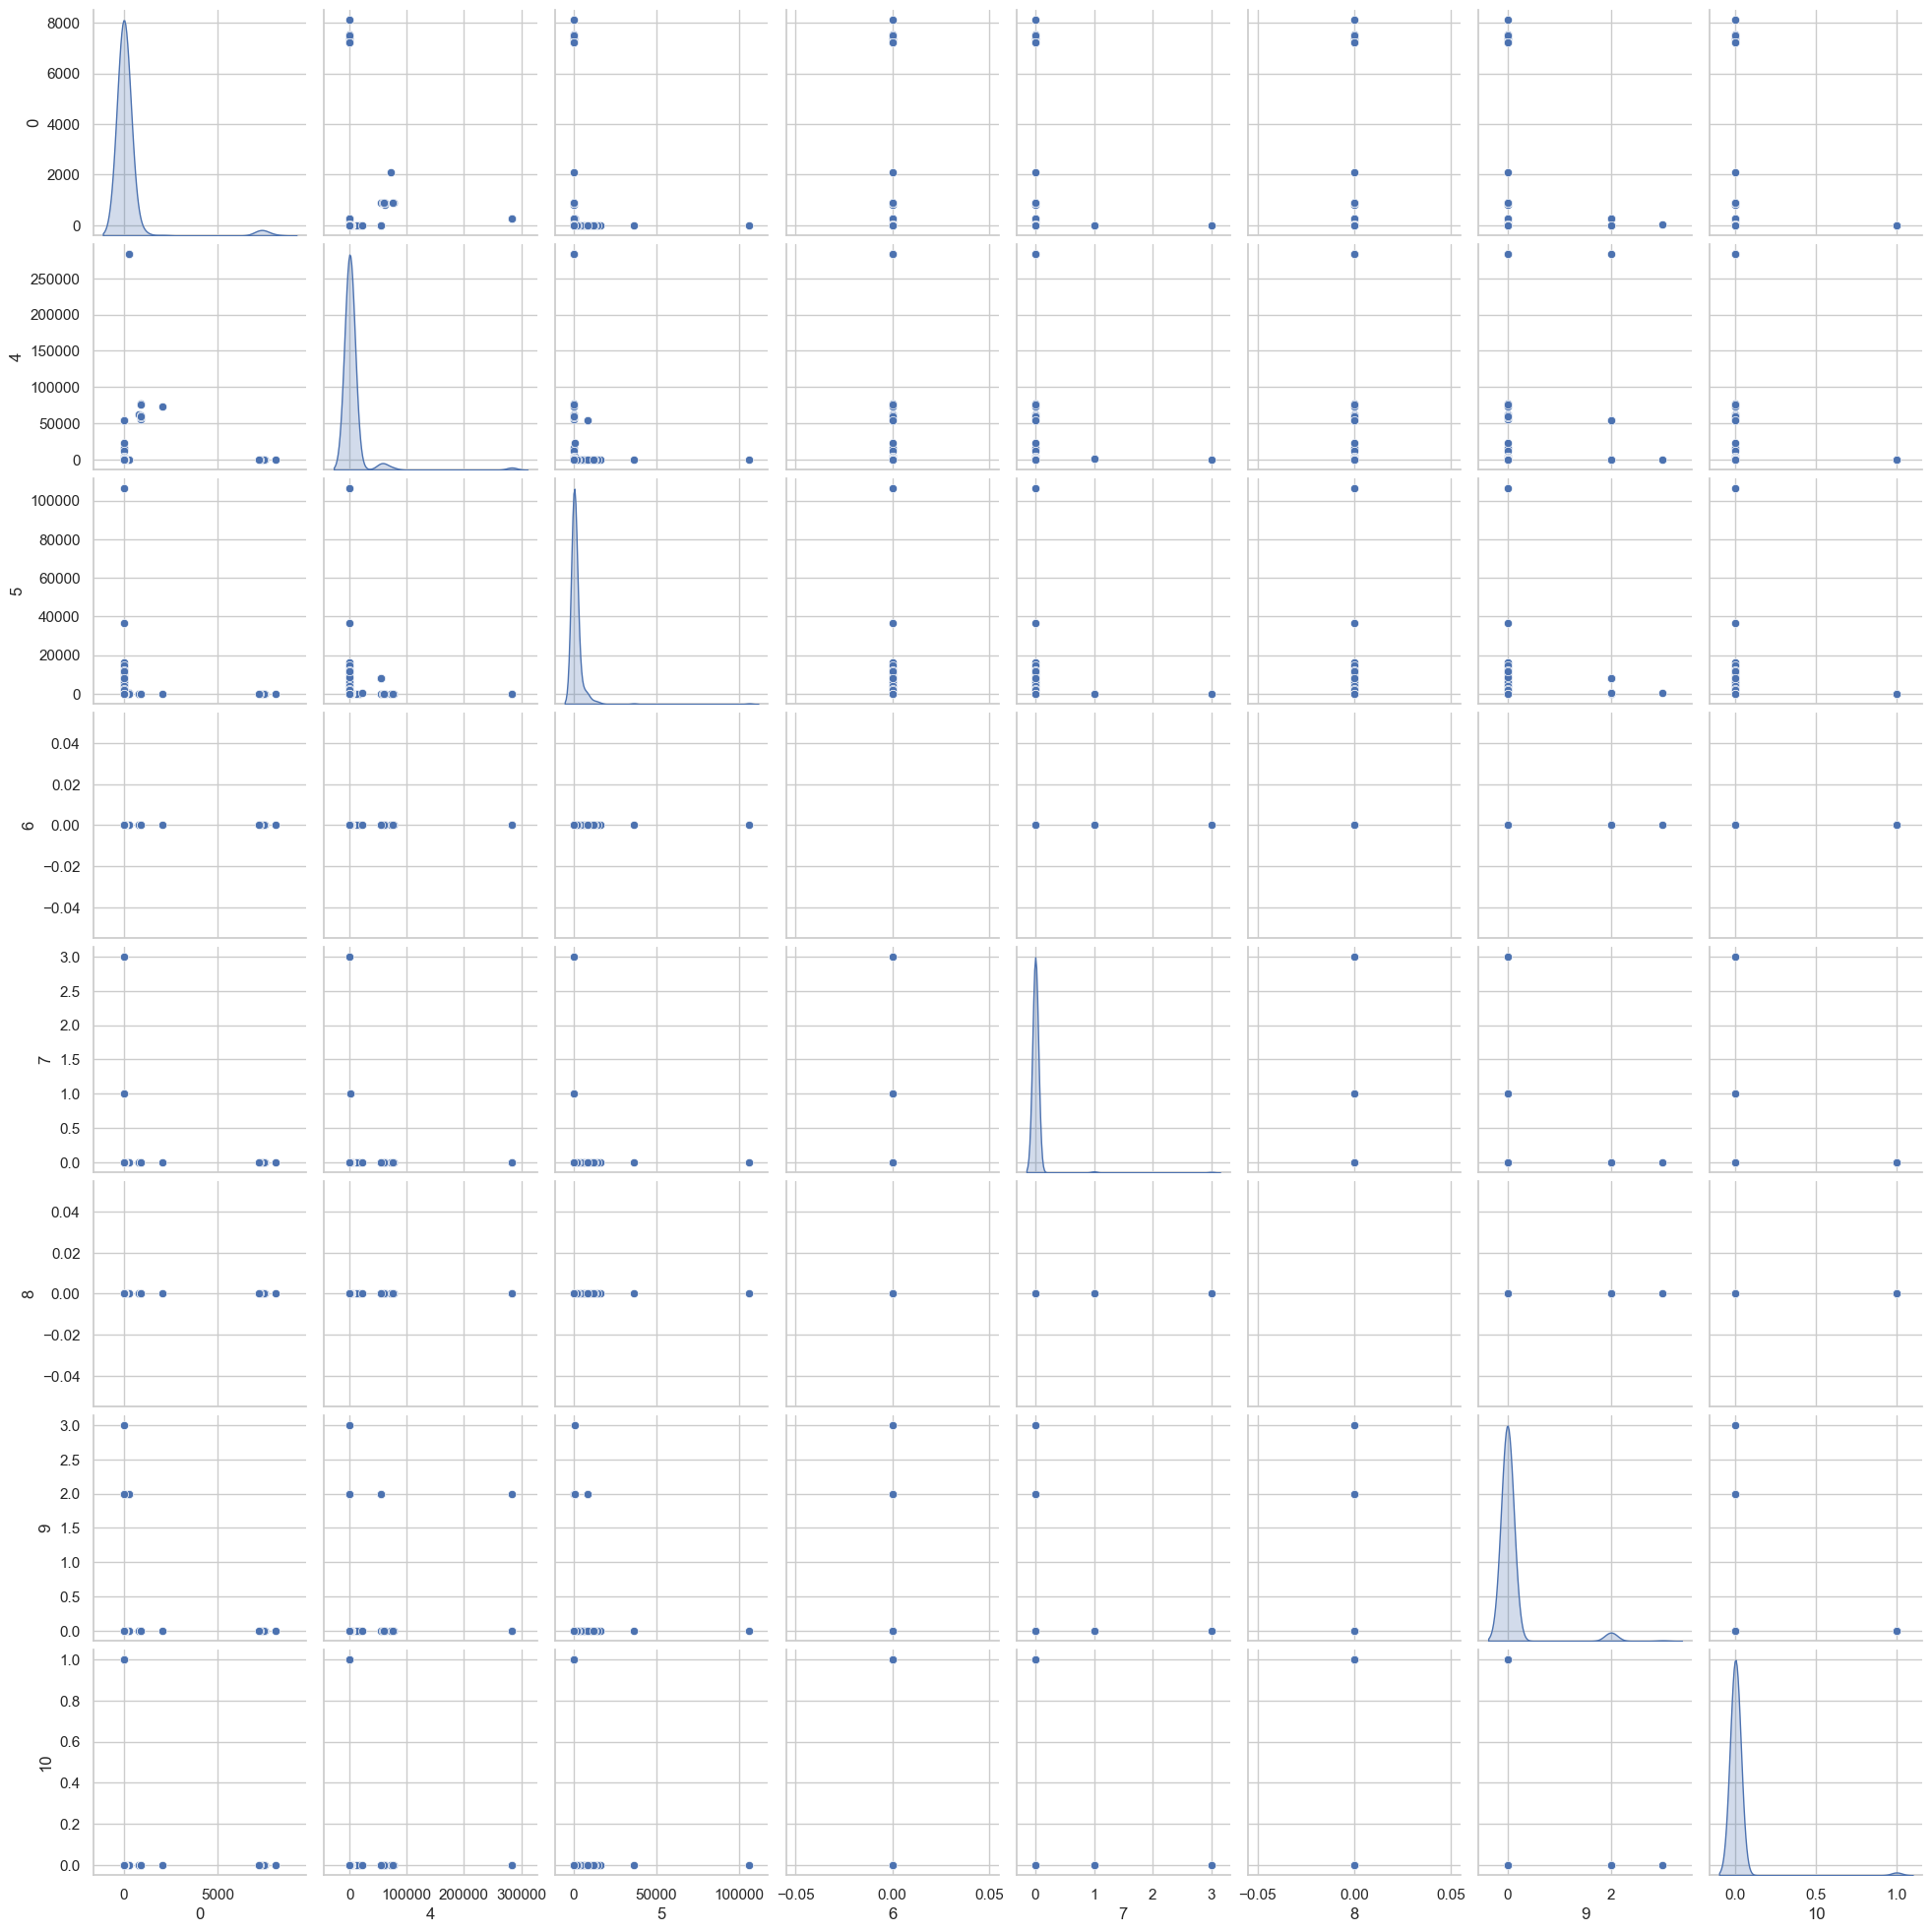

In [26]:
# 9) Correlation heatmap and pairplot (limit to 8 numeric cols)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    cols_for_plots = num_cols[:8]
    corr = df[cols_for_plots].corr()
    plt.figure(figsize=(9,7))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlBu')
    plt.title('Correlation heatmap (selected numeric cols)')
    plt.tight_layout()
    plt.savefig('outputs/nslkdd_correlation_heatmap.png')
    plt.show()
    try:
        sns.pairplot(df[cols_for_plots].dropna().sample(min(400, len(df))), diag_kind='kde')
        plt.savefig('outputs/nslkdd_pairplot_numeric.png')
    except Exception as e:
        print('Pairplot failed:', e)
else:
    print('Not enough numeric columns for correlation/pairplot.')


In [27]:
# 10) Focused examples: show sample rows for DoS-like and SQLi-like subsets
print('DoS-like sample:')
display(df[df['attack_family']=='DoS-like'].head(5))
print('\nSQLi-like sample:')
display(df[df['attack_family']=='SQLi-like'].head(5))


DoS-like sample:


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,label,is_attack,attack_family
30,805,tcp,http,RSTR,76944,1,0,0,0,0,...,0.0,0.00,0.00,0.07,0.07,apache2,14,apache2,1,DoS-like
47,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.0,0.00,0.00,0.06,0.06,back,12,back,1,DoS-like
144,2079,tcp,http,RSTR,72564,0,0,0,0,0,...,0.0,0.00,0.00,0.17,0.18,apache2,14,apache2,1,DoS-like
174,2079,tcp,http,RSTR,69644,0,0,0,0,0,...,0.0,0.00,0.00,0.17,0.19,apache2,14,apache2,1,DoS-like
202,0,tcp,http,S0,0,0,0,0,0,0,...,0.0,0.65,0.65,0.32,0.32,apache2,18,apache2,1,DoS-like



SQLi-like sample:


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,label,is_attack,attack_family
5478,2,tcp,telnet,SF,398,3881,0,0,1,1,...,0.0,0.0,0.0,0.02,0.0,sqlattack,1,sqlattack,1,SQLi-like
8125,2,tcp,telnet,SF,398,3881,0,0,1,1,...,0.0,0.0,0.0,0.00,0.0,sqlattack,1,sqlattack,1,SQLi-like


In [28]:
# 11) Insights summary
insights = []
n_missing = missing_df[missing_df['percent']>0].shape[0]
if n_missing>0:
    insights.append(f'{n_missing} columns contain missing values (see outputs/missingness heatmap)')
else:
    insights.append('No missing values detected.')

insights.append(f'Total rows: {len(df):,}; Total cols: {df.shape[1]}')
insights.append(f"Benign vs Malicious counts: {df['is_attack'].value_counts().to_dict()}")
if 'attack_family' in df.columns:
    insights.append('Attack family coarse distribution saved to outputs/nslkdd_attack_family_distribution.png')
if rule_like:
    insights.append('Rule-complexity proxy computed for column: ' + rl)

print('EDA Insights:')
for s in insights:
    print('- ', s)

print('All plots saved to outputs/')


EDA Insights:
-  No missing values detected.
-  Total rows: 22,544; Total cols: 46
-  Benign vs Malicious counts: {1: 12833, 0: 9711}
-  Attack family coarse distribution saved to outputs/nslkdd_attack_family_distribution.png
All plots saved to outputs/
